In [1]:
import pickle
import random

import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
import numpy as np
import pandas as pd
import scienceplots

from dataset import EuXFELCurrentDataset, EuXFELLPSDataset
from legacy import SupervisedCurrentProfileInference, SupervisedLPSInference
from nils.reconstruction_module_after_diss import master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal
from utils import current2formfactor

math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [2]:
plt.style.use(["science", "ieee"])

In [3]:
matplotlib.rcParams["text.latex.preamble"] += r" \usepackage{siunitx}"
matplotlib.rcParams["text.latex.preamble"] += r" \usepackage{bm}"
matplotlib.rcParams["text.latex.preamble"]

'\\usepackage{amsmath} \\usepackage{amssymb} \\usepackage{siunitx} \\usepackage{bm}'

In [4]:
current_model = SupervisedCurrentProfileInference.load_from_checkpoint(
    "virtual-diagnostics-euxfel-current-legacy/og6sdbm0/checkpoints/epoch=76-step=29876.ckpt"
)
current_model.eval()

lps_model = SupervisedLPSInference.load_from_checkpoint(
    "virtual-diagnostics-euxfel-lps-legacy/mptc9vmu/checkpoints/epoch=95-step=35136.ckpt"
)
lps_model.eval()

print("Loaded models!")

Loaded models!


In [5]:
with open("data/zihan/train_scalers_current.pkl", "rb") as f:
    current_scalers = pickle.load(f)
current_dataset_test = EuXFELCurrentDataset(
    stage="test",
    normalize=True,
    rf_scaler=current_scalers["rf"],
    formfactor_scaler=current_scalers["formfactor"],
    current_scaler=current_scalers["current"],
    bunch_length_scaler=current_scalers["bunch_length"],
)

with open("data/zihan/train_scalers_lps.pkl", "rb") as f:
    lps_scalers = pickle.load(f)
lps_dataset_test = EuXFELLPSDataset(
    stage="test",
    normalize=True,
    rf_scaler=lps_scalers["rf"],
    formfactor_scaler=lps_scalers["formfactor"],
    lps_image_scaler=lps_scalers["lps_image"],
    lps_range_scaler=lps_scalers["lps_range"],
)

plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['font.size'] = 8.0


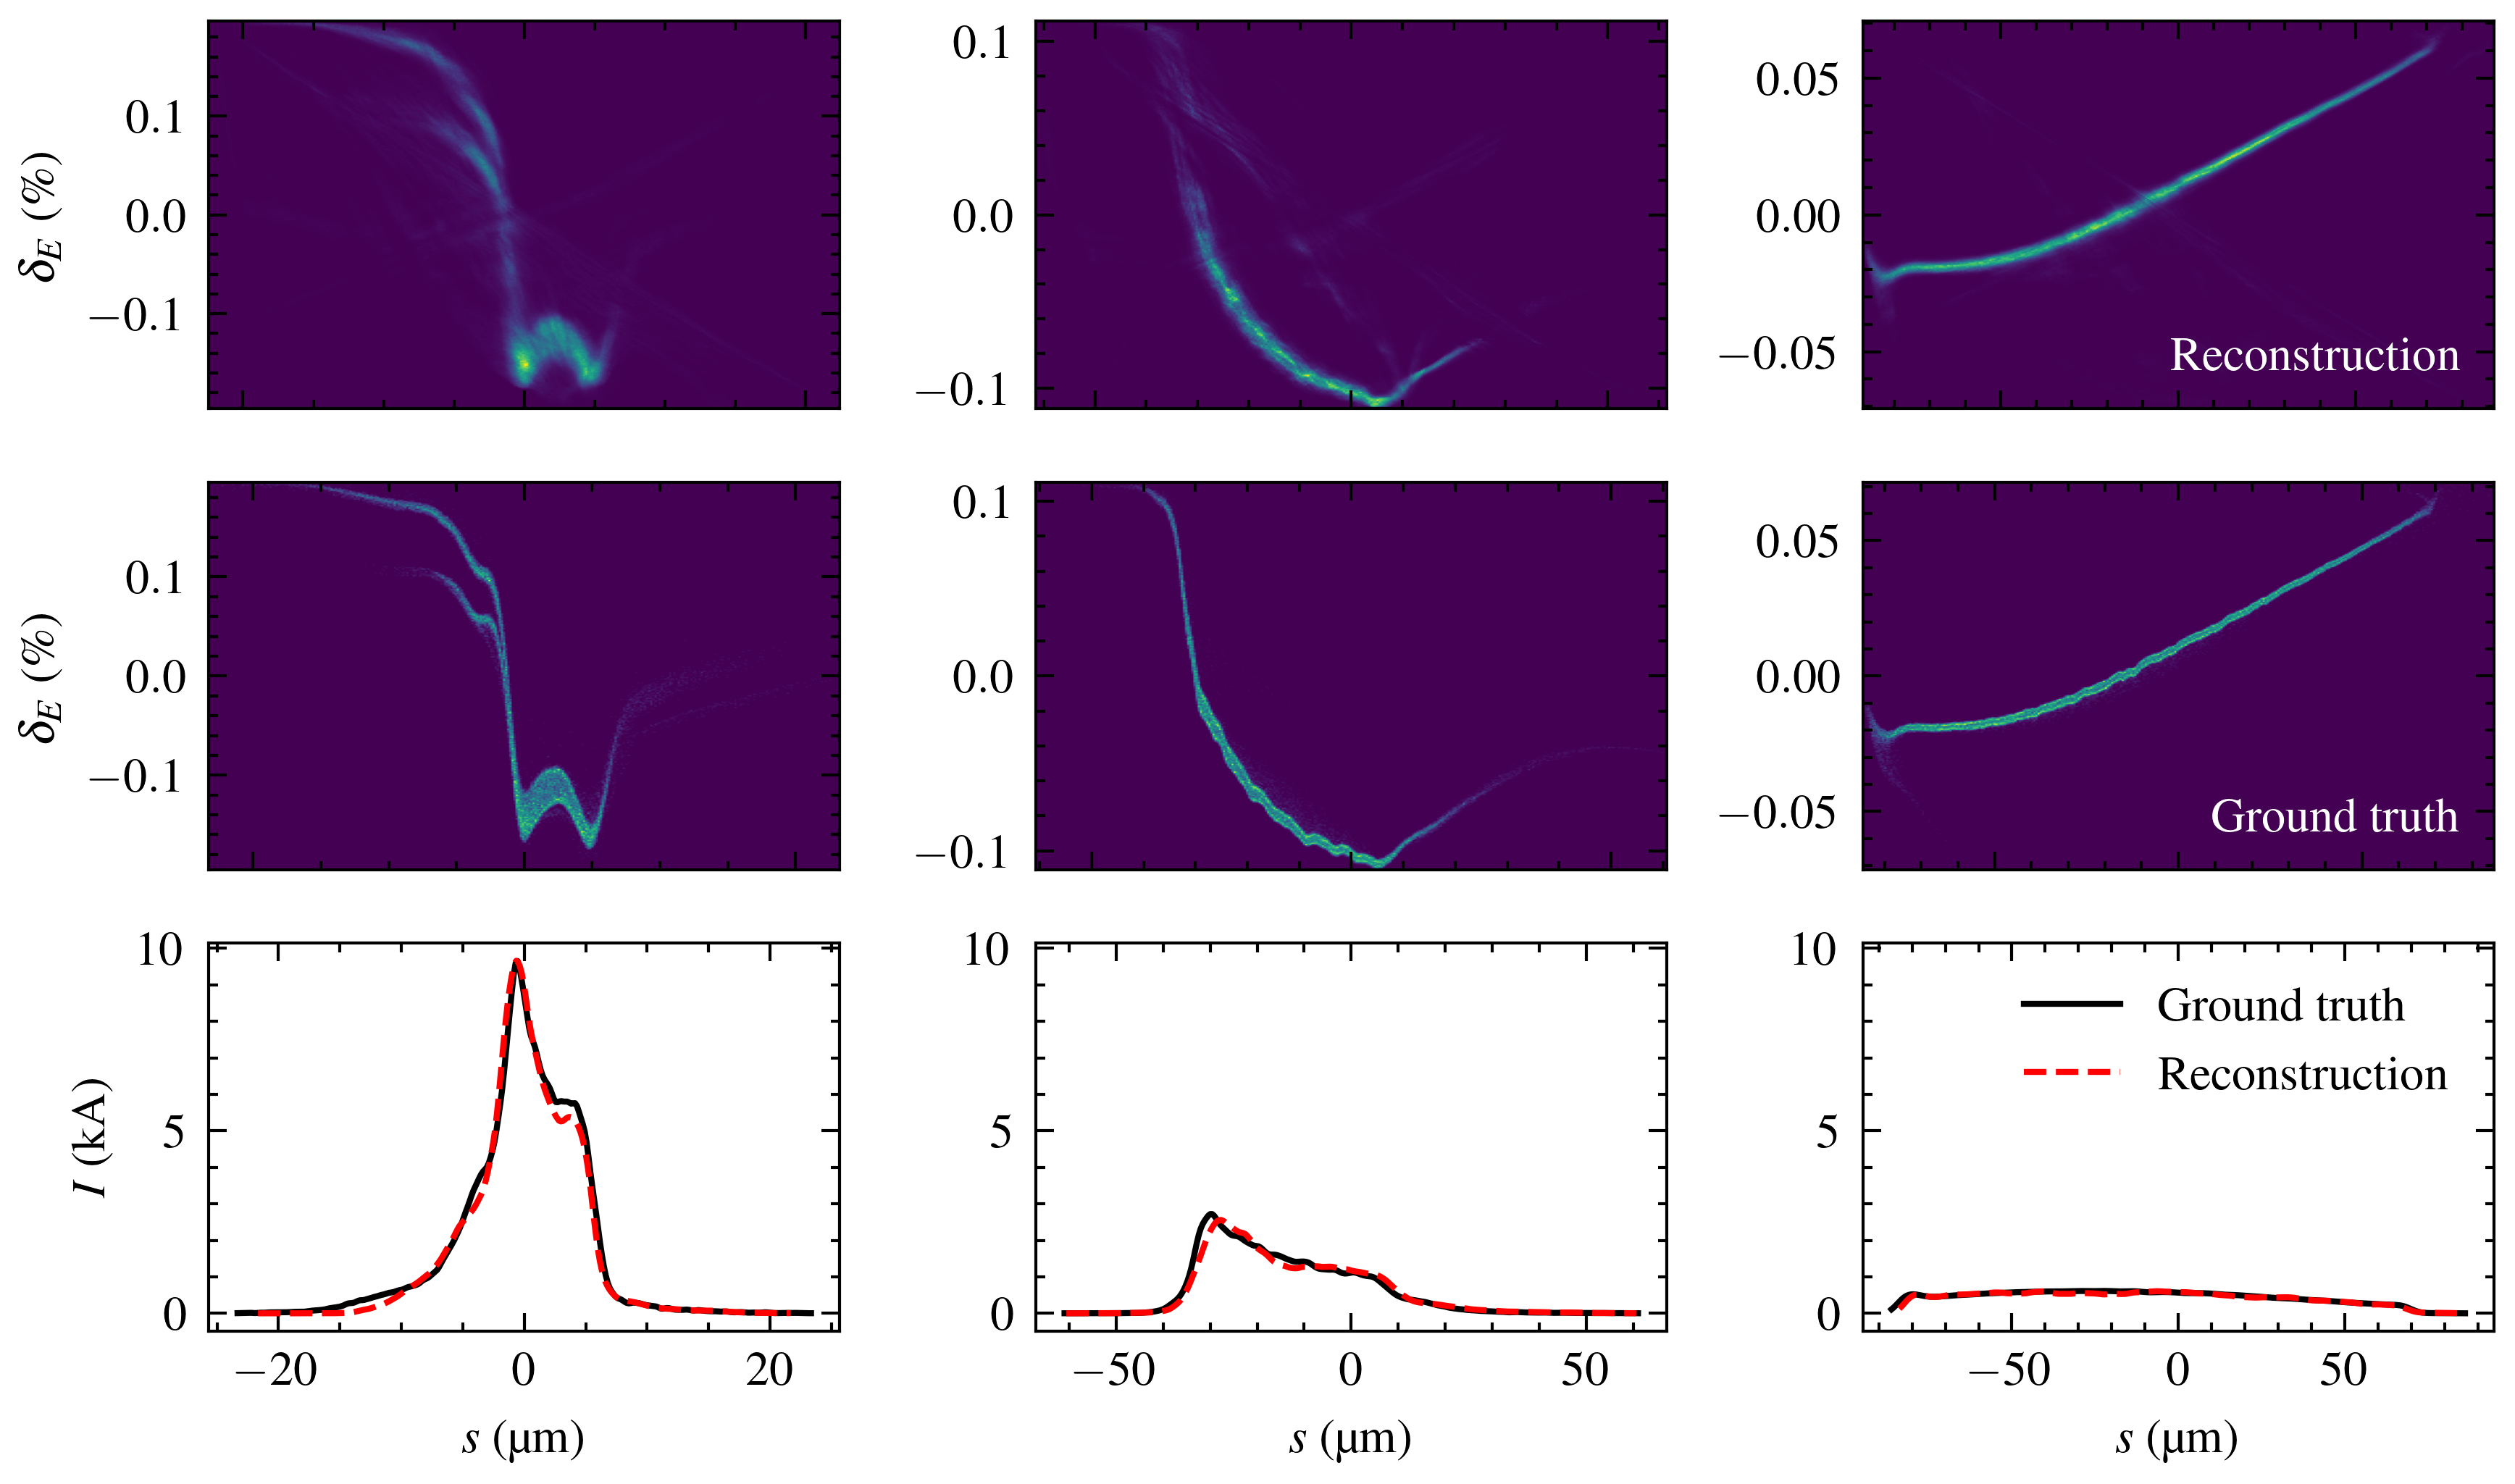

In [6]:
random.seed("IPAC")
# random.seed(24)
num_examples = 4
scale = 1.25
cmap = "viridis"
cmap_cutoff = 0
samples = random.choices(range(len(lps_dataset_test)), k=num_examples)

# Swap and filter plot columns around
samples[0], samples[3] = samples[3], samples[0]
samples[1], samples[3] = samples[3], samples[1]
samples = samples[:3]
samples[1], samples[2] = samples[2], samples[1]

print(f"{plt.rcParams['xtick.labelsize'] = }")
print(f"{plt.rcParams['font.size'] = }")
# print(f"{plt.rcParams = }")

fig, axs = plt.subplots(3, len(samples), figsize=(426.79 / 72, 426.79 / 72 * 0.60))

for i, sample in enumerate(samples):
    (_, _), (current_profile, bunch_length) = current_dataset_test[sample]
    (rf_settings, formfactor), (lps_image, lps_range) = lps_dataset_test[sample]

    x_rf = rf_settings.reshape((1, 5))
    x_formfactor = formfactor.reshape((1, 240))

    y_hat_current_profile, y_hat_bunch_length = current_model(x_rf, x_formfactor)
    y_hat_lps_image, y_hat_lps_range = lps_model(x_rf, x_formfactor)

    predicted_current_profile = current_scalers["current"].inverse_transform(
        y_hat_current_profile.detach().numpy()
    )
    predicted_bunch_length = current_scalers["bunch_length"].inverse_transform(
        y_hat_bunch_length.detach().numpy()
    )
    predicted_lps_image = (
        lps_scalers["lps_image"]
        .inverse_transform(y_hat_lps_image.detach().numpy().reshape(1, 300 * 300))
        .reshape(1, 300, 300)
    )
    predicted_lps_range = lps_scalers["lps_range"].inverse_transform(
        y_hat_lps_range.detach().numpy()
    )

    real_ss = np.linspace(
        -current_dataset_test.bunch_lengths[sample][0] / 2,
        current_dataset_test.bunch_lengths[sample][0] / 2,
        num=300,
    )
    predicted_ss = np.linspace(
        -predicted_bunch_length[0][0] / 2, predicted_bunch_length[0][0] / 2, num=300
    )

    # nils_frequencies, nils_formfactors, nils_formfactor_noise, nils_detlim = (
    #     get_crisp_signal(
    #         real_ss,
    #         current_dataset_test.current_profiles[sample],
    #         n_shots=10,
    #         which_set="both",
    #     )
    # )
    # recon_time, recon_current, _, _, _, _ = master_recon(
    #     nils_frequencies,
    #     nils_formfactors,
    #     nils_formfactor_noise,
    #     nils_detlim,
    #     1e-10,
    #     method="KKstart",
    #     channels_to_remove=[],
    #     show_plots=False,
    # )

    predicted_lps_image[predicted_lps_image < cmap_cutoff] = np.nan
    axs[0, i].imshow(
        np.flipud(predicted_lps_image[0].transpose()),
        vmin=0,
        aspect="auto",
        cmap=cmap,
        extent=(
            -predicted_lps_range[0, 0] / 2 * 1e6,
            predicted_lps_range[0, 0] / 2 * 1e6,
            -predicted_lps_range[0, 1] / 2 * 1e2,
            predicted_lps_range[0, 1] / 2 * 1e2,
        ),
    )

    real_lps_image = lps_dataset_test.lps_images[sample].copy()
    real_lps_image[real_lps_image < cmap_cutoff] = np.nan
    axs[1, i].imshow(
        np.flipud(real_lps_image.transpose()),
        vmin=0,
        aspect="auto",
        cmap=cmap,
        extent=(
            -lps_dataset_test.lps_ranges[sample, 0] / 2 * 1e6,
            lps_dataset_test.lps_ranges[sample, 0] / 2 * 1e6,
            -lps_dataset_test.lps_ranges[sample, 1] / 2 * 1e2,
            lps_dataset_test.lps_ranges[sample, 1] / 2 * 1e2,
        ),
    )

    axs[2, i].plot(
        real_ss * 1e6,
        current_dataset_test.current_profiles[sample] * 1e-3,
        label="Ground truth",
    )
    axs[2, i].plot(
        predicted_ss * 1e6, predicted_current_profile[0] * 1e-3, label="Reconstruction"
    )
    # plt.plot(recon_time, recon_current)
    axs[2, i].set_xlabel(r"$s$ (\unit{\micro\meter})")

axs[0, 0].set_ylabel(r"$\delta_E$ (\unit{\percent})")
axs[1, 0].set_ylabel(r"$\delta_E$ (\unit{\percent})")
axs[2, 0].set_ylabel(r"$I$ (\unit{\kilo\ampere})")
axs[0, len(samples) - 1].text(
    0.95,
    0.1,
    "Reconstruction",
    color="white",
    horizontalalignment="right",
    transform=axs[0, i].transAxes,
)
axs[1, len(samples) - 1].text(
    0.95,
    0.1,
    "Ground truth",
    color="white",
    horizontalalignment="right",
    transform=axs[1, i].transAxes,
)
axs[2, len(samples) - 1].legend()

axs[2, 1].sharey(axs[2, 0])
axs[2, 2].sharey(axs[2, 0])

for ax in axs[0]:
    ax.set_xticklabels([])
for ax in axs[1]:
    ax.set_xticklabels([])

plt.tight_layout()
# plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig("figures/dissertation_prediction_examples.pdf")
plt.show()

In [7]:
# from pathlib import Path

# import ocelot as oc
# from ocelot.gui.accelerator import show_e_beam
# import pandas as pd

# plt.style.use("default")

# df = pd.read_pickle("data/zihan/data_20220905_test.pkl")

# filename = Path(df.iloc[sample]["file"])
# particles = oc.load_particle_array("data/zihan/particles" / filename)
# show_e_beam(particles)

In [8]:
# plt.style.use(["science", "no-latex"])

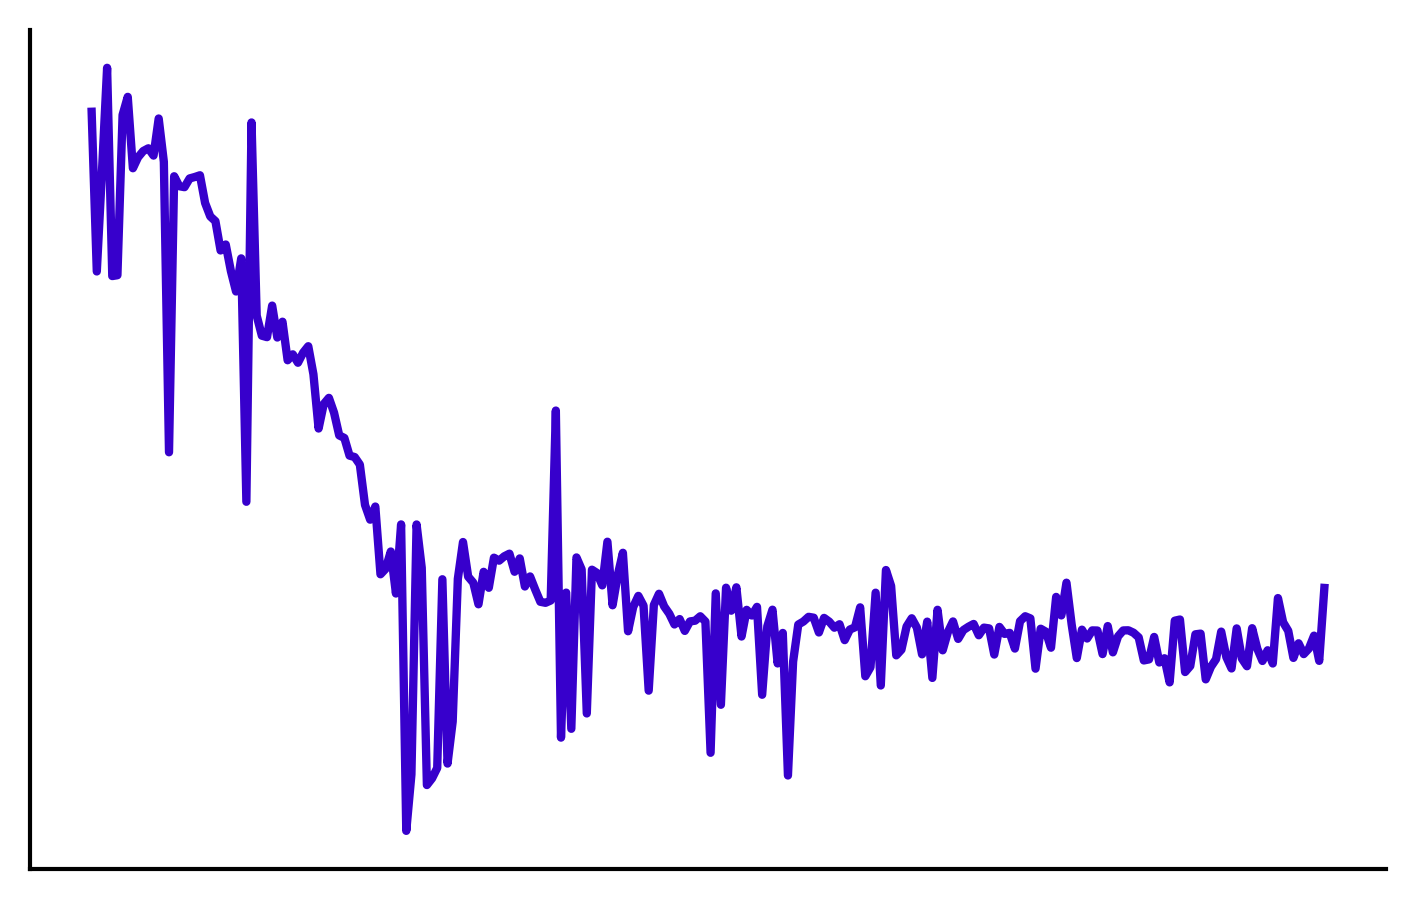

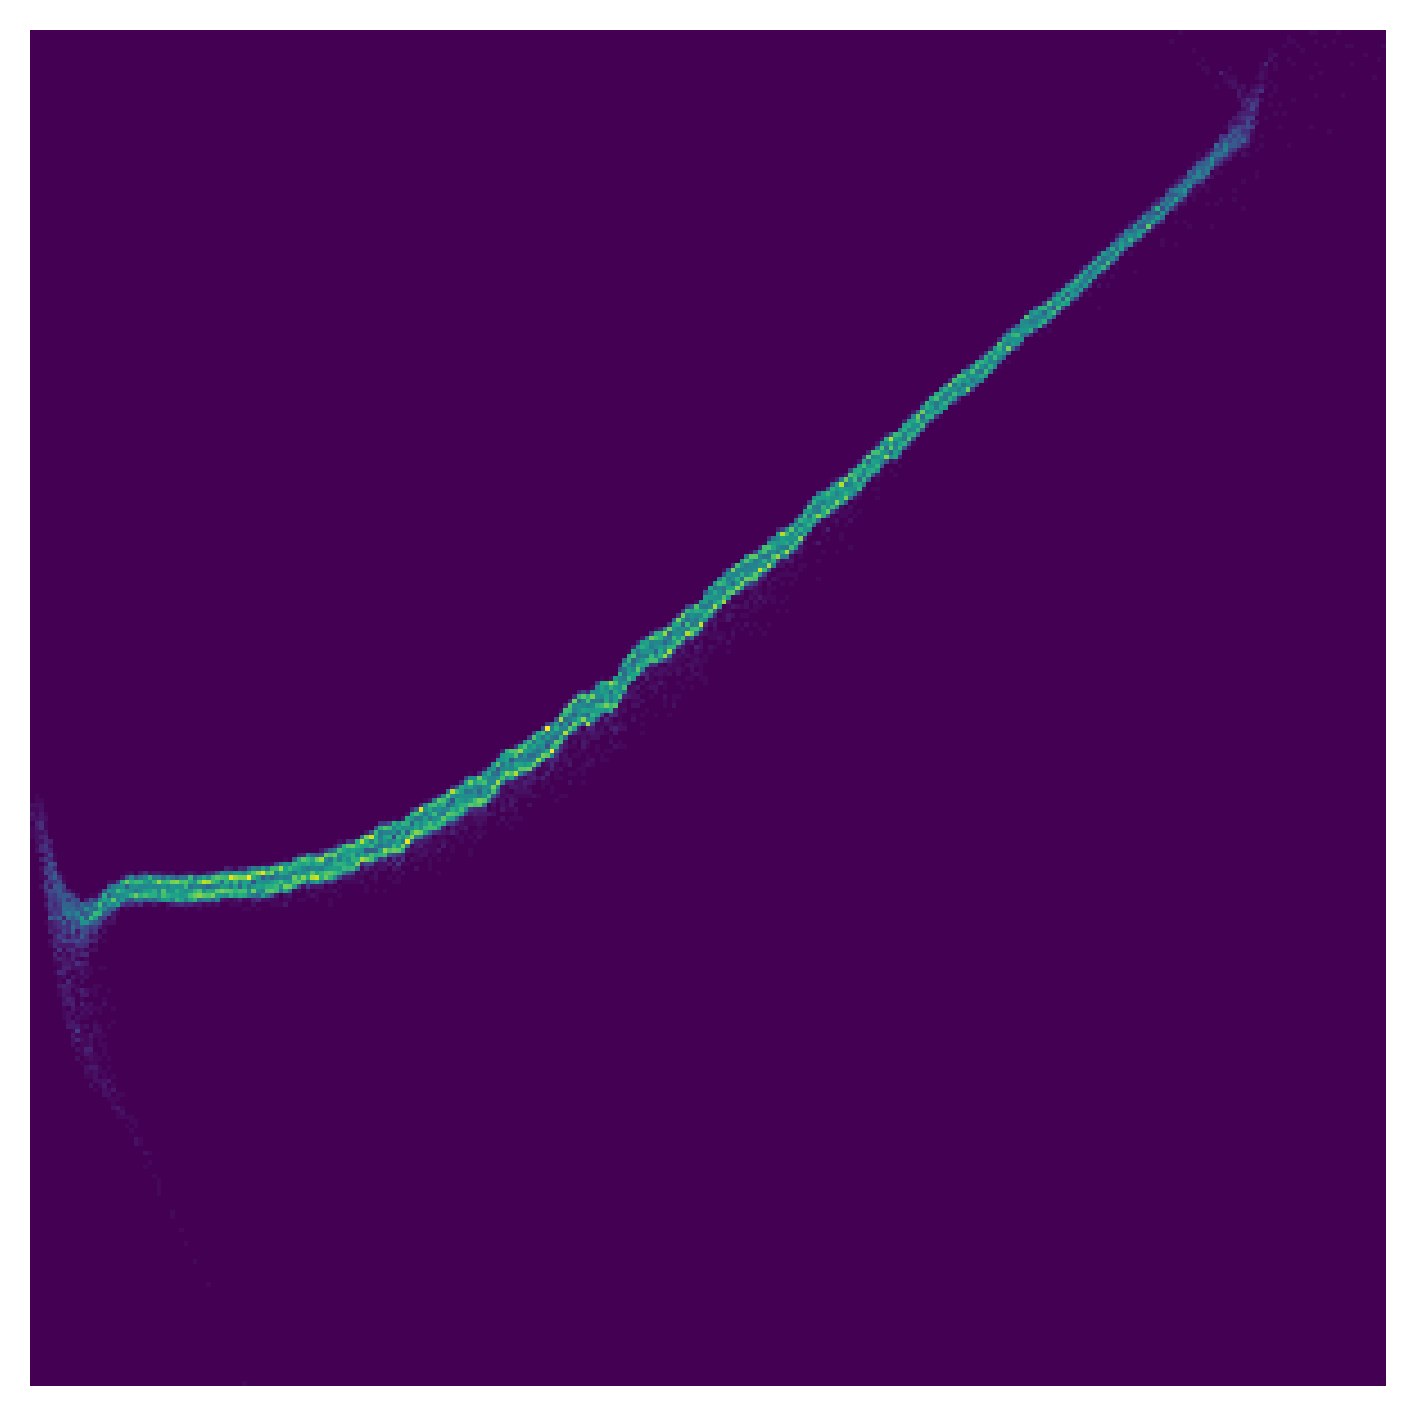

In [9]:
# For neural network flowchart in dissertation

plt.figure(figsize=(90 / 72 * 2, 59 / 72 * 2))
plt.plot(lps_dataset_test.formfactors[samples[-1]], color="#3700CC")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xticks([])
# plt.xlabel(r"Frequency (\unit{\tera\hertz})")
plt.yticks([])
# plt.ylabel(r"$\bm{x}_{\unit{\tera\hertz}} \mathrm{(|F|)}$")
plt.tight_layout()
plt.savefig("figures/dissertation_flowchart_formfactor.svg", dpi=300)
plt.show()

plt.imshow(
    np.flipud(lps_dataset_test.lps_images[samples[-1]].transpose()),
    vmin=0,
    interpolation="nearest",
)
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/dissertation_flowchart_lps_image.svg", dpi=300)
plt.show()